A cleaner version of the previouse notebook with the same name. This is an approach which looks at effects by focusing
on individual cell probe context_pair combinations.
The main changes are:
using exclusively the dprime mean as a metric of amplitude.
using alpha = 0.05 instead of 0.01

Preparing figures with better quality for EARS talk.


1. for a cell, for a probe, find all context_pairs and classify them as
    * silence - self
    * silence _ different [1,2,3]
    * self - different [1,2,3]
    * different [1,2] - different [2,3]
    * in total 10 different context_pairs classified into 4 groups
2. repeat for each probe
4. count only signficant dprimes, report the metric. and mean the metric across categories
5. report the mean and the proportion of significant dprimes.

In [1]:
from pathlib import Path
import itertools as itt

import joblib as jl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from statannot import add_stat_annotation
from cycler import cycler

from src.data.region_map import region_map

[nems.configs.defaults INFO] Saving log messages to /tmp/nems/NEMS 2021-03-09 170827.log


In [2]:
plt.style.use('dark_background')
# modify figure color cycler back to the default one
color_cycler = cycler(color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
                            '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])

params = {'legend.fontsize': 'medium',
          'axes.labelsize': 15,
          'axes.titlesize': 20,
          'axes.spines.top': False,
          'axes.spines.right': False,
          'axes.prop_cycle': color_cycler,
          'xtick.labelsize': 11,
          'ytick.labelsize': 11,
          'lines.markersize': 8,
          'figure.titlesize': 30,
          'figure.figsize': [6,6],
          'figure.autolayout':False,
          'svg.fonttype': 'none',
          'font.sans-serif': 'Arial'
          }

plt.rcParams.update(params)


In [3]:
# pulls DF, removes unused columns and data, refactor redunant id columns and create probe_id
DF = jl.load(Path(f'../data/210302_consolidated_summary_DF_alpha_0.05/dprime_absolute-None_montecarlo-1000_raster_fs-30_reliability-0.1_smoothing_window-0_zscore-True'))

# no need for means or mean policy, working on permutations only
ff_probe = DF.probe != 'mean'
ff_pairs = DF.context_pair != 'mean'
ff_stim = DF.stim_type == 'permutations'
ff_mean = DF.mean_signif_type == 'shuffles'

ff_analylis = DF.analysis.isin(['SC', 'fdPCA'])
ff_corr = DF.mult_comp_corr.isin(['time', 'consecutive_2', 'consecutive_3'])

good_cols =['analysis', 'mult_comp_corr', 'region', 'siteid',  'cellid', 'context_pair',
            'probe', 'metric', 'value']
filtered = DF.loc[ff_stim & ff_mean & ff_pairs & ff_probe & ff_analylis & ff_corr, good_cols]


filtered['id'] = filtered['cellid'].fillna(value=filtered['siteid'])
# filtered['id_probe'] = filtered[['id', 'probe']].agg('_'.join, axis=1)
filtered = filtered.drop(columns=['cellid', 'siteid'])

filtered['value'] = filtered['value'].fillna(value=0)

print('duplicated columns?: ', any(filtered.loc[:,[col for col in filtered.columns if col !='value']].duplicated()))

duplicated columns?:  False


In [4]:
# creates a new column relating probe with  context pairs
ctx = np.asarray([row.split('_') for row in filtered.context_pair], dtype=int)
prb = np.asarray(filtered.probe, dtype=int)

silence = ctx == 0
same = ctx == prb[:,None]
different = np.logical_and(~silence, ~same)

name_arr = np.full_like(ctx, np.nan, dtype=object)
name_arr[silence] = 'sile'
name_arr[same] = 'same'
name_arr[different] = 'diff'
comp_name_arr = np.apply_along_axis('_'.join, 1, name_arr)

# swaps clasification names to not have repetitions i.e. diff_same == same_diff
comp_name_arr[np.where(comp_name_arr == 'self_sile')] = 'sile_self'
comp_name_arr[np.where(comp_name_arr == 'diff_sile')] = 'sile_diff'
comp_name_arr[np.where(comp_name_arr == 'diff_same')] = 'same_diff'
comp_name_arr[np.where(comp_name_arr == 'same_sile')] = 'sile_same'


filtered['trans_pair'] = comp_name_arr
classDF = filtered

# selects multiple comparisons correction
## Single data points

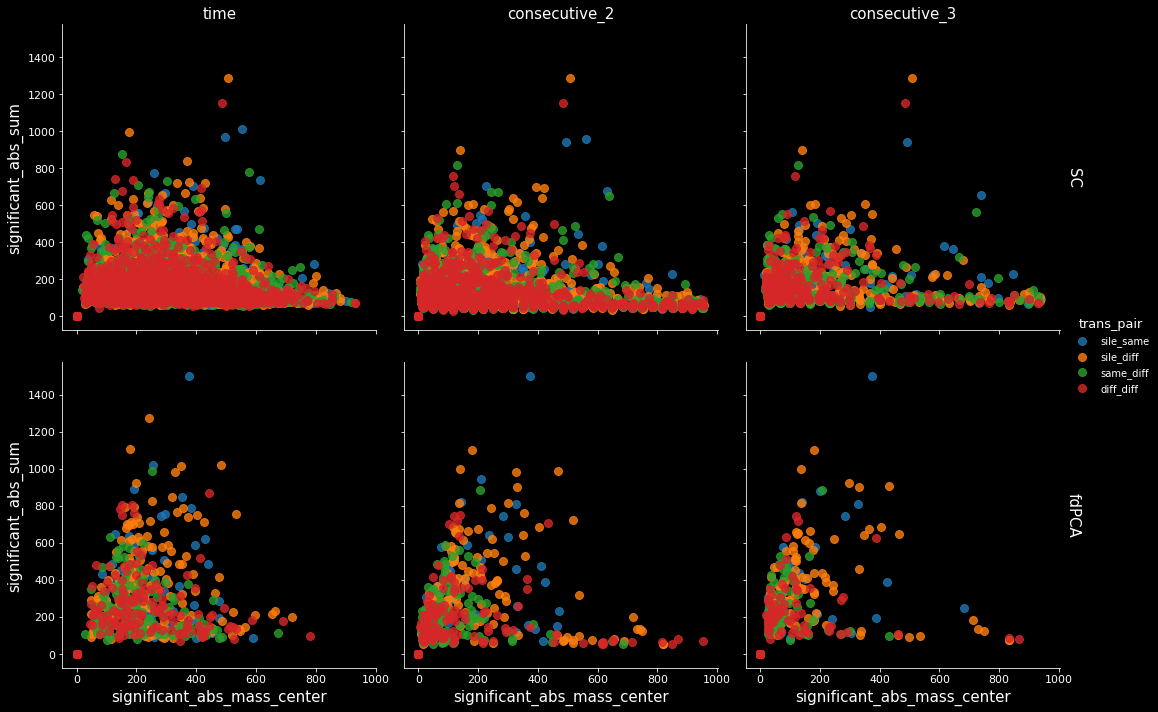

In [7]:
# per data poin
piv_idx = [col for col in classDF.columns if col not in ('metric', 'value')]
toplot = classDF.pivot_table(index=piv_idx, columns='metric', values='value', aggfunc='first').reset_index()

cols = ['time','consecutive_2', 'consecutive_3',]
rows = ['SC', 'fdPCA']
g = sns.lmplot(x='significant_abs_mass_center', y='significant_abs_sum', data=toplot,
               hue='trans_pair', row='analysis', col='mult_comp_corr',
               fit_reg=False, sharex=True, sharey=True,
               row_order=rows, col_order=cols)

g.set_titles(template="")
g._margin_titles = True
g.set_titles(row_template="{row_name}", col_template="{col_name}")

In [18]:
# filters the array for all further plotting.
print(classDF.columns)
correction = 'consecutive_3'
ff_comps = classDF.mult_comp_corr == correction
ff_analylis = classDF.analysis.isin(['SC', 'fdPCA'])

# ff_metric = classDF.metric.isin(['significant_abs_mass_center', 'significant_abs_sum'])
ff_metric = classDF.metric.isin(['significant_abs_mass_center', 'significant_abs_mean'])

ord_cols = ['analysis', 'region', 'id', 'context_pair', 'trans_pair', 'probe', 'metric', 'value']
filtered = classDF.loc[ff_comps & ff_analylis & ff_metric, ord_cols]

# rename metrics for ease of ploting
filtered['metric'] = filtered['metric'].replace({'significant_abs_mass_center': 'center of mass (ms)',
                                                 'significant_abs_mean': "mean d'",
                                                 'significant_abs_sum': "d' integral"})

good_cols = [col for col in ord_cols if col not in ['value']]
print('duplicates?: ', np.any(filtered.loc[:, good_cols].duplicated()))
print('nans?: ', any(filtered['value'].isna()))
pivot_idx = [col for col in ord_cols if col not in ['value', 'metric']]
pivoted = filtered.pivot_table(index=pivot_idx, columns='metric', values='value', aggfunc='first').reset_index()
pivoted.head()

Index(['analysis', 'mult_comp_corr', 'region', 'context_pair', 'probe',
       'metric', 'value', 'id', 'trans_pair'],
      dtype='object')
duplicates?:  False
nans?:  False


metric,analysis,region,id,context_pair,trans_pair,probe,center of mass (ms),mean d'
0,SC,A1,AMT020a-02-1,0_1,sile_diff,2,0.0,0.0
1,SC,A1,AMT020a-02-1,0_1,sile_diff,3,0.0,0.0
2,SC,A1,AMT020a-02-1,0_1,sile_diff,4,0.0,0.0
3,SC,A1,AMT020a-02-1,0_1,sile_same,1,0.0,0.0
4,SC,A1,AMT020a-02-1,0_2,sile_diff,1,0.0,0.0


For each transition_pair category, calculates the mean metric, as well the the total number of values
(index x context_pair x probe), and the number of singificant values.

These numbers are categorized by region (A1 or PEG) and by analysis type (SC, dPCA).


In [23]:
# counts the total number of values for each comparison (SC, fDPCA) x (sile_diff, sile_same, diff_diff, same_diff)
# counts the proportion of signifciant vs non singificant(zero-zero) values
# decimates the more numerous comparisons??

# set the array to group by id, context_pair, and probe. Keeping analysis, region and transision_pair
# the final array should have analysis, region and trans pair as rowns, and total count, and significants as columns

def nozero_mean(arr):
    arr[arr==0] = np.nan
    return np.nanmean(arr)

def nozero_count(arr):
    return np.sum(arr>0)

group_ready = pivoted.set_index(['analysis', 'region', 'trans_pair']).loc[:, filtered.metric.unique()]

agg_funcs = {'center of mass (ms)': [('mean duration', nozero_mean)],
             "mean d'": [('mean amplitude', nozero_mean),
                                     ('total', 'size'),
                                     ('n_signif', nozero_count)]}

grouped = group_ready.groupby(['analysis', 'region', 'trans_pair']).agg(agg_funcs)
grouped.columns = grouped.columns.droplevel(0)
grouped['percentage significant'] = grouped.n_signif / grouped.total * 100

grouped

mean duration  mean amplitude  total  n_signif  \
analysis region trans_pair                                                   
SC       A1     diff_diff      129.954786        1.253440   3048     167.0   
                same_diff      137.824877        1.219568   3048     180.0   
                sile_diff      197.906654        1.170995   3048     265.0   
                sile_same      225.256465        1.089933   1016      76.0   
         PEG    diff_diff      183.908435        1.170024   2148     146.0   
                same_diff      213.469746        1.215863   2148     149.0   
                sile_diff      190.956718        1.202232   2148     175.0   
                sile_same      201.498936        1.205719    716      67.0   
fdPCA    A1     diff_diff      105.673710        1.674731    108      38.0   
                same_diff       86.193536        1.907713    108      30.0   
                sile_diff      188.616721        1.703010    108      58.0   
                sile_same      148.695309        1.699413     36      19.0   
         PEG    diff_diff      149.168185        1.571888     96      32.0   
                same_diff       94.031012        1.588388     96      33.0   
                sile_diff      142.925743        1.651199     96      52.0   
                sile_same      138.050211        1.644664     32      19.0   

                            percentage significant  
analysis region trans_pair                          
SC       A1     diff_diff                 5.479003  
                same_diff                 5.905512  
                sile_diff                 8.694226  
                sile_same                 7.480315  
         PEG    diff_diff                 6.797020  
                same_diff                 6.936685  
                sile_diff                 8.147114  
                sile_same                 9.357542  
fdPCA    A1     diff_diff                35.185185  
                same_diff                27.777778  
                sile_diff                53.703704  
                sile_same                52.777778  
         PEG    diff_diff                33.333333  
                same_diff                34.375000  
                sile_diff                54.166667  
                sile_same                59.375000

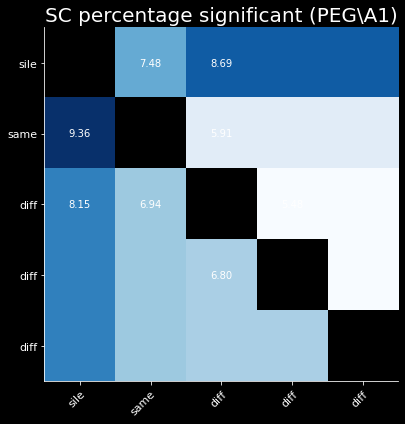

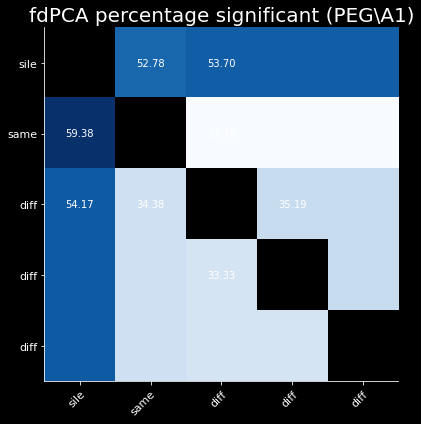

In [56]:
# paired relation plot
# defines the grid (5 * 5) with correct indexing


def pairwise_heatmap(value, up_var, lo_var, analysis):
    grid_lab = np.asarray(['sile', 'same', 'diff', 'diff', 'diff'])
    grid_arr = np.full((5,5), np.nan)
    swap_dict = {'self_sile': 'sile_self',
                 'diff_sile': 'sile_diff',
                 'diff_same': 'same_diff',
                 'same_sile': 'sile_same'}

    up_idx = np.triu_indices(5,1)
    lo_idx = np.tril_indices(5,-1)

    # relates labes to upper and lower
    upper_label = [f'{grid_lab[t1]}_{grid_lab[t2]}' for t1, t2 in
             zip(up_idx[0], up_idx[1])]

    lower_label = [f'{grid_lab[t1]}_{grid_lab[t2]}' for t1, t2 in
             zip(lo_idx[0], lo_idx[1])]
    lower_label = [swap_dict[lab] if lab in list(swap_dict.keys()) else lab for lab in lower_label]

    # iterates and fills upper triangle
    up_vals = list()
    for uplab in upper_label:
        up_vals.append(grouped.loc[(analysis, up_var, uplab), value])

    lo_vals = list()
    for lolab in lower_label:
        lo_vals.append(grouped.loc[(analysis, lo_var, lolab), value])

    grid_arr[up_idx] = up_vals
    grid_arr[lo_idx] = lo_vals


    fig, ax = plt.subplots()
    im = ax.imshow(grid_arr, cmap='Blues')

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(grid_lab)))
    ax.set_yticks(np.arange(len(grid_lab)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(grid_lab)
    ax.set_yticklabels(grid_lab)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")


    # Loop over labelse and  set values the first time
    for unique_lab in set(upper_label):
        uy = up_idx[0][upper_label.index(unique_lab)]
        ux = up_idx[1][upper_label.index(unique_lab)]
        text = ax.text(ux, uy, f'{grid_arr[uy, ux]:.2f}',
                           ha="center", va="center", color="w")

    for unique_lab in set(lower_label):
        ly = lo_idx[0][lower_label.index(unique_lab)]
        lx = lo_idx[1][lower_label.index(unique_lab)]
        text = ax.text(lx, ly, f'{grid_arr[ly, lx]:.2f}',
                           ha="center", va="center", color="w")



    ax.set_title(f"{analysis} {value} ({lo_var}\\{up_var})")
    fig.tight_layout()
    plt.show()

    return fig


_ = pairwise_heatmap('percentage significant', 'A1', 'PEG', 'SC')
_ = pairwise_heatmap('percentage significant', 'A1', 'PEG', 'fdPCA')

multiple comparisons correction  consecutive_3


/auto/users/mateo/miniconda3/envs/context_probe_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:32: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 


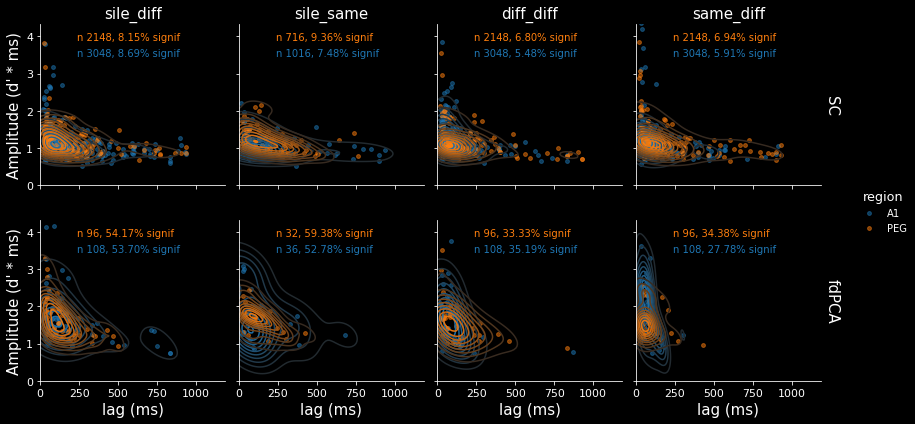

In [30]:
# grid with proportion anotations
print('multiple comparisons correction ', correction)
def anotated_nozero_scatter(x, y, **kws):
    total = x.shape[0]
    x = x[x>0]
    y = y[y>0]
    region = kws['label']
    n_signif = len(x)
    percent_good = n_signif / total * 100

    ax = plt.gca()
    ax.scatter(x, y, s=15, alpha=0.5, **kws)
    sns.kdeplot(x, y, ax=ax, **kws)
    ax.set_xlim(0,ax.get_xlim()[1])
    ax.set_ylim(0,ax.get_ylim()[1])

    offset = 0.8 if region == 'A1' else 0.9
    ax.text(.2, offset, f'n {total}, {percent_good:.2f}% signif', transform=ax.transAxes,  **kws)

# note that this ploting fuction uses the unfiltered dataframe, since it calculates the proportion of
# significant values
g = sns.FacetGrid(data=pivoted, row='analysis', col='trans_pair', hue='region',
                  sharex=True, sharey=True, legend_out=True)
g.map(anotated_nozero_scatter, 'center of mass (ms)', "mean d'")
g.set_titles(template="")
g._margin_titles = True
g.set_titles(row_template="{row_name}", col_template="{col_name}")
g.set_axis_labels('lag (ms)', "Amplitude (d' * ms)")
g.add_legend()
fig = g.fig
fig.tight_layout(rect=(0,0,0.98,0))


# explained variance plots

[(('interaction', 'A1'), ('interaction', 'PEG')), (('context', 'A1'), ('context', 'PEG')), (('probe', 'A1'), ('probe', 'PEG')), (('time', 'A1'), ('time', 'PEG'))]


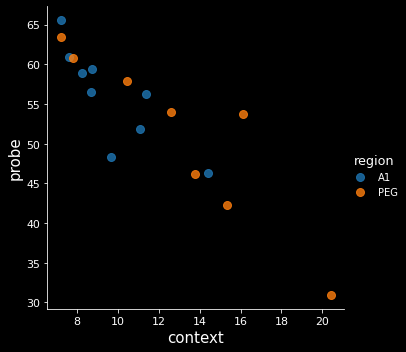

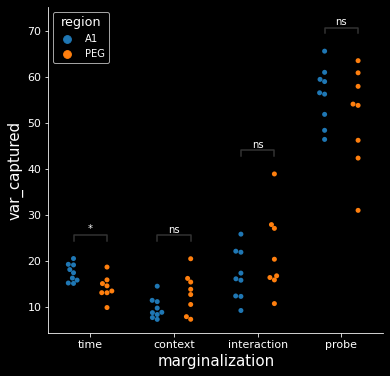

In [47]:
varDF = jl.load(Path('../data/210302_variance_explained_DF/dprime_absolute-None_montecarlo-1000_raster_fs-30_reliability-0.1_smoothing_window-0_zscore-True'))
varDF['region'] = [region_map[site] for site in varDF.siteid]
varDF.rename(columns={'cpt': 'interaction', 'ct':'context', 'pt':'probe', 't':'time'}, inplace=True)
# print(varDF)
g = sns.lmplot(x='context', y='probe', hue='region', data=varDF, fit_reg=False)


fig, ax = plt.subplots()
molten = varDF.melt(id_vars=['siteid', 'region'], var_name='marginalization', value_name='var_captured')
marg_ord = ['time', 'context', 'interaction', 'probe']
area_ord = ['A1', 'PEG']
ax = sns.swarmplot(x='marginalization', y='var_captured', hue='region',
                   order=marg_ord, hue_order=area_ord, dodge=True, data=molten, ax=ax)


area_pairs = [((marg, 'A1'), (marg, 'PEG')) for marg in molten.marginalization.unique()]
print(area_pairs)
stat_tests = add_stat_annotation(ax, plot='boxplot', data=molten,
                                 x='marginalization', y='var_captured', hue='region',
                                 order=marg_ord, hue_order=area_ord,
                                 box_pairs=area_pairs, test='Mann-Whitney', text_format='star',
                                 loc='inside', verbose=0)


# Parameter comparisons with significance tests
going over old parameter comparison between regions. Since I am no longer geting means of context_pairs and probe but
rather treating each id-trans_pair-probe as an obervation (and only those that are significant) the compoarisosn are no
longer paired. May the gods of statistics have mercy of my code.

### all together

In [49]:
metrics = filtered.metric.unique()
id_vars = [col for col in pivoted.columns if col not in metrics]
catDF = pivoted.melt(id_vars=id_vars, value_vars=metrics,
                   var_name='metric', value_name='value')
catDF = catDF.loc[catDF.value > 0, :]

### between areas

/auto/users/mateo/miniconda3/envs/context_probe_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator


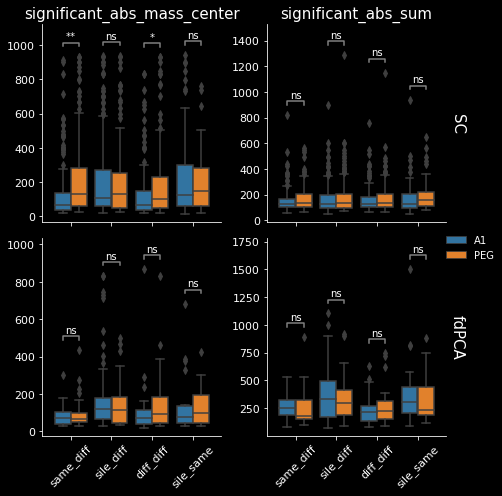

In [42]:
trans_ord = catDF.trans_pair.unique()
reg_ord = catDF.region.unique()

area_pairs = [(('diff_diff', 'A1'), ('diff_diff', 'PEG')),
              (('same_diff', 'A1'), ('same_diff', 'PEG'))]
area_pairs = [((trans, 'A1'), (trans, 'PEG')) for trans in catDF.trans_pair.unique()]

def anot_box(data, **kws):
    # print(kws)
    ax = plt.gca()
    ax = sns.boxplot(data=data, ax=ax,
                     order=trans_ord, hue_order=reg_ord,
                     palette=sns.color_palette(), **kws)
    kws['color'] = 'gray'
    _ = add_stat_annotation(ax, plot='boxplot', data=data,
                            order=trans_ord, hue_order=reg_ord,
                            box_pairs=area_pairs,
                            test='Mann-Whitney', text_format='star',
                            loc='inside', verbose=0, **kws)


g = sns.FacetGrid(row='analysis', col='metric',data=catDF,
                  sharey=False, sharex=True)
for ax in np.ravel(g.axes):
    ax.set_xticklabels(ax.get_xticks(), rotation = 45)
g.map_dataframe(anot_box, x='trans_pair', y='value', hue='region')

g.set_titles(template="")
g._margin_titles = True
g.set_titles(row_template="{row_name}", col_template="{col_name}")
g.add_legend()
fig = g.fig
fig.set_size_inches(7,7)
fig.tight_layout(rect=(0,0,0.95,1))

collapsing by transition pairs

### beteween transitions pairs, by area ...

/auto/users/mateo/miniconda3/envs/context_probe_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator


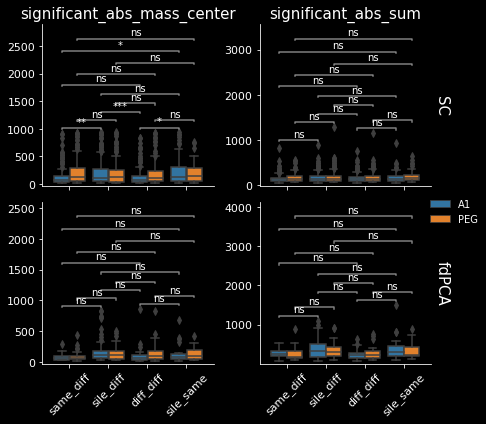

In [43]:
trans_ord = catDF.trans_pair.unique()
reg_ord = catDF.region.unique()

trans_pp = [((tp1, reg), (tp2, reg)) for (tp1, tp2), reg
            in itt.product(itt.combinations(catDF.trans_pair.unique(),2), catDF.region.unique())]

def anot_box(data, **kws):
    # print(kws)
    ax = plt.gca()
    ax = sns.boxplot(data=data, ax=ax,
                     order=trans_ord, hue_order=reg_ord,
                     palette=sns.color_palette(), **kws)
    kws['color'] = 'gray'
    _ = add_stat_annotation(ax, plot='boxplot', data=data,
                            order=trans_ord, hue_order=reg_ord,
                            box_pairs=trans_pp,
                            test='Mann-Whitney', text_format='star',
                            loc='inside', verbose=0, comparisons_correction='bonferroni', **kws)


g = sns.FacetGrid(row='analysis', col='metric', data=catDF,
                  sharey=False, sharex=True)
for ax in np.ravel(g.axes):
    ax.set_xticklabels(ax.get_xticks(), rotation = 45)
g.map_dataframe(anot_box, x='trans_pair', y='value', hue='region')
g.set_titles(template="")
g._margin_titles = True
g.set_titles(row_template="{row_name}", col_template="{col_name}")
g.add_legend()
fig = g.fig
fig.tight_layout(rect=(0,0,0.95,1))

### between transition pairs, pooling areas

/auto/users/mateo/miniconda3/envs/context_probe_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator


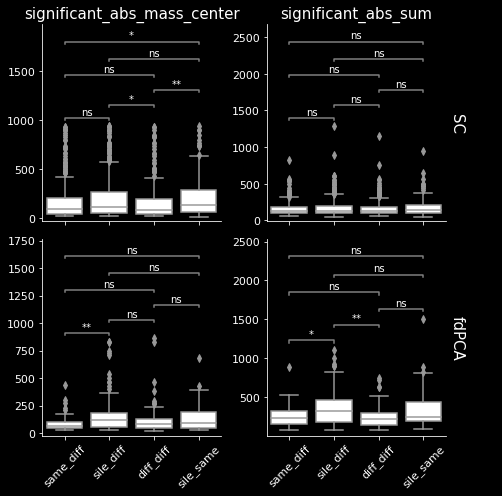

In [44]:
trans_ord = catDF.trans_pair.unique()
trans_pp = [(tp1, tp2) for tp1, tp2
            in itt.combinations(catDF.trans_pair.unique(),2)]

def anot_box(data, **kws):
    # print(kws)
    ax = plt.gca()
    ax = sns.boxplot(data=data, ax=ax, order=trans_ord, palette=['white'], **kws)
    kws['color'] = 'gray'
    _ = add_stat_annotation(ax, plot='boxplot', data=data,
                            order=trans_ord,
                            box_pairs=trans_pp,
                            test='Mann-Whitney', text_format='star',
                            loc='inside', verbose=0, comparisons_correction='bonferroni', **kws)


g = sns.FacetGrid(row='analysis', col='metric',data=catDF,
                  sharey=False, sharex=True)
for ax in np.ravel(g.axes):
    ax.set_xticklabels(ax.get_xticks(), rotation = 45)
g.map_dataframe(anot_box, x='trans_pair', y='value')
g.set_titles(template="")
g._margin_titles = True
g.set_titles(row_template="{row_name}", col_template="{col_name}")
g.add_legend()
fig = g.fig
fig.set_size_inches(7, 7)
fig.tight_layout(rect=(0,0,0.95,1))

### between analysis types (SC, fdPCA)

/auto/users/mateo/miniconda3/envs/context_probe_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator


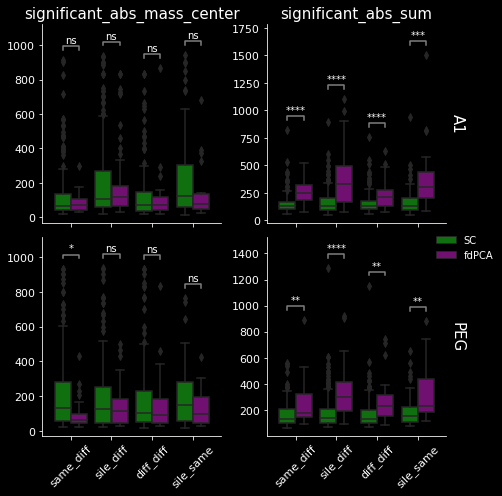

In [45]:

trans_ord = catDF.trans_pair.unique()
ana_ord = catDF.analysis.unique()
analysis_pairs =[((tp, 'SC'), (tp, 'fdPCA')) for tp in catDF.trans_pair.unique()]

def anot_box(data, **kws):
    # print(kws)
    ax = plt.gca()
    ax = sns.boxplot(data=data, ax=ax, order=trans_ord, palette=['green', 'purple'], **kws)
    kws['color'] = 'gray'
    _ = add_stat_annotation(ax, plot='boxplot', data=data,
                            order=trans_ord, hue_order=ana_ord,
                            box_pairs=analysis_pairs,
                            test='Mann-Whitney', text_format='star',
                            loc='inside', verbose=0, comparisons_correction='bonferroni', **kws)


g = sns.FacetGrid(row='region', col='metric',data=catDF,
                  sharey=False, sharex=True)
for ax in np.ravel(g.axes):
    ax.set_xticklabels(ax.get_xticks(), rotation = 45)
g.map_dataframe(anot_box, x='trans_pair', y='value', hue='analysis')
g.set_titles(template="")
g._margin_titles = True
g.set_titles(row_template="{row_name}", col_template="{col_name}")
g.add_legend()
fig = g.fig
fig.set_size_inches(7, 7)
fig.tight_layout(rect=(0,0,0.95,1))


# repeat some of these plots using the mean d' instead of integral.

In [46]:
amplitude = 'significant_abs_mean'
metrics = ['significant_abs_mass_center', amplitude]
id_vars = [col for col in pivoted.columns if col not in metrics]
catDF = pivoted.melt(id_vars=id_vars, value_vars=metrics,
                   var_name='metric', value_name='value')
catDF = catDF.loc[catDF.value > 0, :]

### between areas

/auto/users/mateo/miniconda3/envs/context_probe_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator


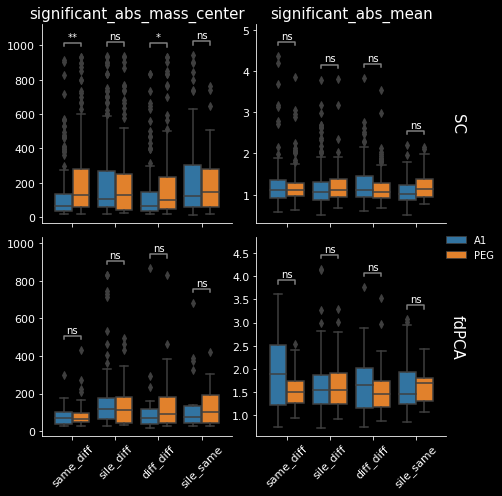

In [47]:
trans_ord = catDF.trans_pair.unique()
reg_ord = catDF.region.unique()

area_pairs = [(('diff_diff', 'A1'), ('diff_diff', 'PEG')),
              (('same_diff', 'A1'), ('same_diff', 'PEG'))]
area_pairs = [((trans, 'A1'), (trans, 'PEG')) for trans in catDF.trans_pair.unique()]

def anot_box(data, **kws):
    # print(kws)
    ax = plt.gca()
    ax = sns.boxplot(data=data, ax=ax,
                     order=trans_ord, hue_order=reg_ord,
                     palette=sns.color_palette(), **kws)
    kws['color'] = 'gray'
    _ = add_stat_annotation(ax, plot='boxplot', data=data,
                            order=trans_ord, hue_order=reg_ord,
                            box_pairs=area_pairs,
                            test='Mann-Whitney', text_format='star',
                            loc='inside', verbose=0, **kws)


g = sns.FacetGrid(row='analysis', col='metric',data=catDF,
                  sharey=False, sharex=True)
for ax in np.ravel(g.axes):
    ax.set_xticklabels(ax.get_xticks(), rotation = 45)
g.map_dataframe(anot_box, x='trans_pair', y='value', hue='region')

g.set_titles(template="")
g._margin_titles = True
g.set_titles(row_template="{row_name}", col_template="{col_name}")
g.add_legend()
fig = g.fig
fig.set_size_inches(7,7)
fig.tight_layout(rect=(0,0,0.95,1))

### beteween transitions pairs, by area ...

/auto/users/mateo/miniconda3/envs/context_probe_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator


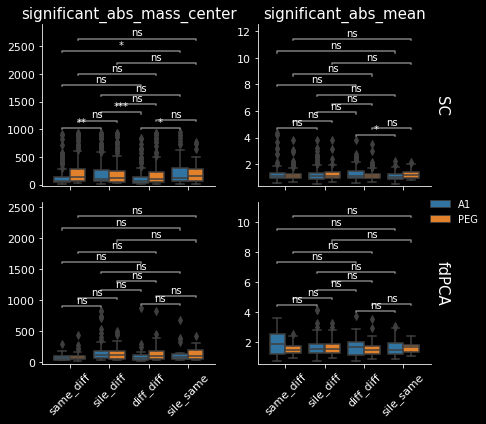

In [48]:
trans_ord = catDF.trans_pair.unique()
reg_ord = catDF.region.unique()

trans_pp = [((tp1, reg), (tp2, reg)) for (tp1, tp2), reg
            in itt.product(itt.combinations(catDF.trans_pair.unique(),2), catDF.region.unique())]

def anot_box(data, **kws):
    # print(kws)
    ax = plt.gca()
    ax = sns.boxplot(data=data, ax=ax,
                     order=trans_ord, hue_order=reg_ord,
                     palette=sns.color_palette(), **kws)
    kws['color'] = 'gray'
    _ = add_stat_annotation(ax, plot='boxplot', data=data,
                            order=trans_ord, hue_order=reg_ord,
                            box_pairs=trans_pp,
                            test='Mann-Whitney', text_format='star',
                            loc='inside', verbose=0, comparisons_correction='bonferroni', **kws)


g = sns.FacetGrid(row='analysis', col='metric', data=catDF,
                  sharey=False, sharex=True)
for ax in np.ravel(g.axes):
    ax.set_xticklabels(ax.get_xticks(), rotation = 45)
g.map_dataframe(anot_box, x='trans_pair', y='value', hue='region')
g.set_titles(template="")
g._margin_titles = True
g.set_titles(row_template="{row_name}", col_template="{col_name}")
g.add_legend()
fig = g.fig
fig.tight_layout(rect=(0,0,0.95,1))

### between transition pairs, pooling areas

/auto/users/mateo/miniconda3/envs/context_probe_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator


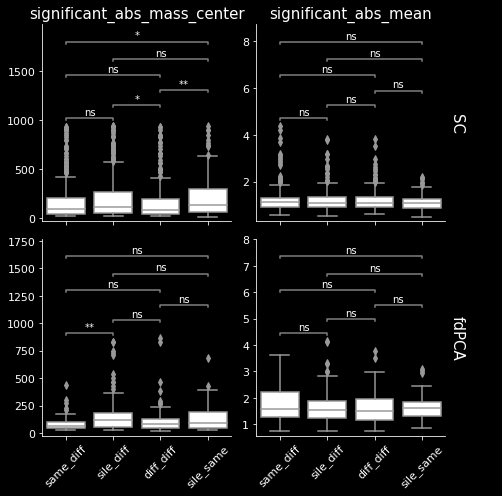

In [49]:
trans_ord = catDF.trans_pair.unique()
trans_pp = [(tp1, tp2) for tp1, tp2
            in itt.combinations(catDF.trans_pair.unique(),2)]

def anot_box(data, **kws):
    # print(kws)
    ax = plt.gca()
    ax = sns.boxplot(data=data, ax=ax, order=trans_ord, palette=['white'], **kws)
    kws['color'] = 'gray'
    _ = add_stat_annotation(ax, plot='boxplot', data=data,
                            order=trans_ord,
                            box_pairs=trans_pp,
                            test='Mann-Whitney', text_format='star',
                            loc='inside', verbose=0, comparisons_correction='bonferroni', **kws)


g = sns.FacetGrid(row='analysis', col='metric',data=catDF,
                  sharey=False, sharex=True)
for ax in np.ravel(g.axes):
    ax.set_xticklabels(ax.get_xticks(), rotation = 45)
g.map_dataframe(anot_box, x='trans_pair', y='value')
g.set_titles(template="")
g._margin_titles = True
g.set_titles(row_template="{row_name}", col_template="{col_name}")
g.add_legend()
fig = g.fig
fig.set_size_inches(7, 7)
fig.tight_layout(rect=(0,0,0.95,1))

### between analysis types (SC, fdPCA)

/auto/users/mateo/miniconda3/envs/context_probe_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator


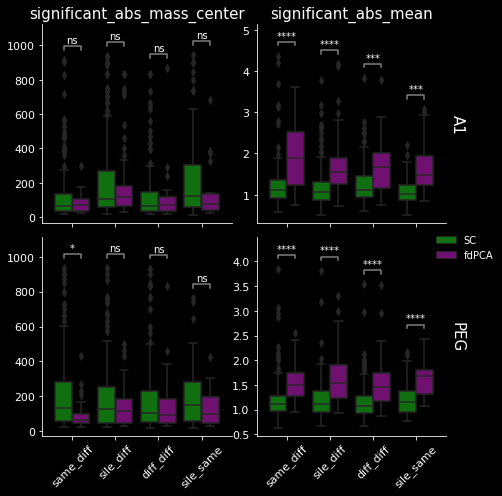

In [50]:

trans_ord = catDF.trans_pair.unique()
ana_ord = catDF.analysis.unique()
analysis_pairs =[((tp, 'SC'), (tp, 'fdPCA')) for tp in catDF.trans_pair.unique()]

def anot_box(data, **kws):
    # print(kws)
    ax = plt.gca()
    ax = sns.boxplot(data=data, ax=ax, order=trans_ord, palette=['green', 'purple'], **kws)
    kws['color'] = 'gray'
    _ = add_stat_annotation(ax, plot='boxplot', data=data,
                            order=trans_ord, hue_order=ana_ord,
                            box_pairs=analysis_pairs,
                            test='Mann-Whitney', text_format='star',
                            loc='inside', verbose=0, comparisons_correction='bonferroni', **kws)


g = sns.FacetGrid(row='region', col='metric',data=catDF,
                  sharey=False, sharex=True)
for ax in np.ravel(g.axes):
    ax.set_xticklabels(ax.get_xticks(), rotation = 45)
g.map_dataframe(anot_box, x='trans_pair', y='value', hue='analysis')
g.set_titles(template="")
g._margin_titles = True
g.set_titles(row_template="{row_name}", col_template="{col_name}")
g.add_legend()
fig = g.fig
fig.set_size_inches(7, 7)
fig.tight_layout(rect=(0,0,0.95,1))

